In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Naključno vzbujanje - zajem signalov

Spomnimo se:

:::{note}

**Frekvenčna prenosna funkcija** $\alpha(\omega)$ predstavlja razmerje med (kompleksnimi) amplitudami harmonskega odziva in vzbujana opazovanega sistema:

$$
	\alpha(\omega) = \frac{X(\omega)}{F(\omega)}
$$

:::

## Zajem signalov za določitev prenosnih funkcij z naključnim vzbujanjem

Določamo razmerje med odzivom sistema in znanim signlom vzbujanja, na podlagi izmerjenih signalov $x(t)$, $f(t)$ pri *naključnem, širokospektralnem, stacionarnem* vzbujanju.

Namen te vaje je spoznati laboratorijsko opremo in izvesti meritve signalov, potrebnih za določitev prenosnih funkcij mehanskega LTI sistema.

:::{admonition} Naloga: Meritev prenosnih funkcij jeklenega nosilca
:class: warning


Pripravite zajemni sistem in opravite meritve odziva (pospeška) jeklenega nosilca na naključno vzbujanje. 

Vsak naj izvede **meritev odziva (pospšeka) nosilca v točki, podani v tabeli podatkov**, ki jo najdete v e-učilnici. 

Strukturo vzbujamo z naključnim širokospektralnim profilom na elektrodinamskem stresalniku preko povezovalne palice (*stingerja*), v pripravljeni točki $0$.

Delo v laboratoriju bo potekalo **skupinsko**. Nalogo sestavljajo trije vsebinski deli, ki so podrobneje opisani spodaj:

1. Postavitev in povezava merilne opreme.
2. Priprava NI MAX + Python programa za generiranje in zajem signalov.
3. Meritev signalov vzbujevalne sile in odziva sistema v različnih točkah pri naključnem vzbujanju.

:::

### Merilni sistem

Merilna veriga je sestavljena iz naslednjih komponent:

* Jeklen nosilec:
    * Dolžina: 500 mm.
    * 11 označenih merilnih mest (na pozicijah $[25, 475]$ mm, razmik $45$ mm).
    * Vzbujanje na lokaciji $0$, meritve odziva na lokacijah $i \in [1, 2, \dots 10]$.


* Zajemna (AI) kartica [NI 9234](https://www.ni.com/sl-si/support/model.ni-9234.html):
    * 4 analogni vhodni kanali (BNC priključek).
    * $\pm$ 5 V.
    * Frekvenca vzorčenja do 51200 Hz (dovoljene vrednosti: $51200 / n$, $n \in [1, 2, 3, \dots, 31]$).
    * 24-bitna ločljvost.



* Vzbujevlana (AO) kartica [NI 9263](https://www.ni.com/sl-si/support/model.ni-9263.html):
    * 4 analogni izhodni kanali.
    * $\pm$ 10 V.
    * Frekvenca vzorčenja do 100 000 Hz.
    * 16-bitna ločljvost.



* Silomer [PCB 208C01](https://www.pcb.com/products?model=208c01):
    * IEPE silomer.
    * BNC povezava z analognim vhodom merilne kartice.
    * Merilno območje: $\pm$ 4.4 N.
    * Občutljivost: podatek na škatli instrumenta.


* Pospeškomer [PCB  333B30](https://www.pcb.com/products?model=333B30):
    * IEPE pospeškomer.
    * BNC povezava z analognim vhodom merilne kartice.
    * Merilno območje: $\pm$ 490 $m/s^2$.
    * Občutljivost: podatek na škatli instrumenta.


* Elektrodinamski stresalnik.
    * Povezava s strukturo preko povezovalne palice (*stingerja*).

* Analogni visokoprepustni filter.
    * frekvenca odreza: 2.8 Hz

* AC Ojačevalnik analognega signala.
    * največja dopustna vhodna napetost: $\pm 1$ V (**ustrezno nastavite največjo napetost izhodnega kanala AO kartice!**)

    **V izogib poškodbam merilne opreme pred meritvijo ojačanje napajalnika postavite na 0!** 
    
    Ustrenzo nastavitev ojačanja poiščite pred začetkom meritve.

* Merilni osebni računalnik (USB povezava).

:::{admonition} 1. Postavitev merilne verige
:class: important

Povežite merilno verigo zajemnega sistema. Pomagajte si z zgornjim opisom meirlne opreme ter spodnjo sliko.

Pri povezavi merilnih zaznaval (pospeškomer, silomer) na merilno kartico lahko uporabite poljubne vhodne kanale. Poskrbite, da boste izbiro upoštevali pri nastavitvi opraivil strojne opreme v aplikaciji NI MAX.

![zajemni-sistem](./images/09/00_zajemni_sistem.png)

:::

:::{admonition} 2. Priprava programa meritve
:class: important

Meritev (generiranje signala vzbujanja in zajem) bomo krmilili v programskem jeziku Python, za komunikacijo z NI merilno opremo pa bomo uporaibili paket [PyDAQmx](https://pythonhosted.org/PyDAQmx/) in vnaprej konfigurirana opravila (*task*-e) za upravljanje strojne opreme z aplikacijo National Instruments Automation explorer ([NI MAX](https://www.ni.com/sl-si/support/documentation/supplemental/21/what-is-ni-measurement---automation-explorer--ni-max--.html)).


Preden lahko v Pythonu vzpostavimo povezavo z merilno opremo, moramo ustrenzo konfigurirati opravila znotraj NI MAX.

![NIMAX](./images/09/01_NIMAX_zagon.png)

V aplikaciji NI MAX sta že pripravljeni opravili za zajem (`PS_random_input`) in generiranje (`PS_random_output`) signalov.
Preverite, da nastavitve opravil ustrezajo predpisanim parametrom zajema in generiranja podakotv:

Glavne nastavitve **zajema** so:
* Dva kanala: *sila* in *pospešek* (IEPE).
* Frekvenca vzorčenja: 25600 Hz,
* Trajanje vsakega zajetega segmenta: 2 s,
* Kontinuirano zajemanje segmentov (`Continuous Samples`),
* Število zajetih segmentov: 5.

![input_task](./images/09/02_input_task.png)


Glavne nastavitve **generiranja** so:
* Ena kanal: *naetost* signala na stresalniku.
* Število vzorcev v sekundi: 20000 Hz
* Trajanje vsakega generirranega segmenta: 2 s,
* Kontinuirano generiranje segmentov (`Continuous Samples`).
* Profil naključnega vzbujevlanega signala konstantne amplitude na območju $[10, 3000] Hz$,
* Povprečne amplitude vzbujevalne sile: **1 N RMS**.

![output_task](./images/09/03_output_task.png)


**Python Program** naj v zanki:
* V zanki (za vsak zajeti segment):
    * Z uporabo paketa `PyDAQmx` zajema kanale segmenta,
    * Za vsak segment prikazuje graf zajetih signalov v času in PSD-ja signalov.
* Po koncu meritve (ko so zajeti vsi segmenti):
    * Shrani zajete podatke v datoteko poljubnega formata.

Uporabite lahko že pripravljen {download}`Python program zajema<./data/09/meritev_python.zip>`. Po potrebi ga spremenite, da bodo parametri meritve ustrezali predpisanim (zgoraj).

**Pozor:** Vse nastavitve parametrov merilne opreme (nastavitev kanalov, občutjivost, frekenca vzorčenja, enote, št. vzorcev v segmentu) nastavite v NI MAX task-u! V Python programu nastavite parametre, povezane z obdelavo signalov (št. zajetih segmentov, profil signala vzbujanja, shranjevanje podatkov v datoteke).

:::


### Meritev

:::{admonition} 3. Izvedba meritve signalov
:class: important

Vsak naj zajame predpisano število segmentov meritve odziva sistema v točki, predpisani v podatih naloge.

Ker uporabljamo eno samo zaznavalo pospeška, je treba tega pred meritvijo namestiti na ustrezno merilno mesto. Za pritrditev uporabite majhno količino voščenega lepila.

![wax](./images/09/05_UJ_0216_Beeswax.png)

*Pred začetkom meritve nastavite ojačanaje ojačevalnika signla tako, da boste v meritvi dosegli predpisano povprečno amplitudo sile (1 N RMS)!* **Preliminarno meritev začnite z ojačanjem 0, in tega ustrezno povečajte.**

Ko ste ustrezno nastaivli merilni sistem, NI MAX opravila in parametre Python programa, meritev poženete z zagonom funkcije `IO_meritev()` v poglavju "Meritev" Python programa.

Pri izvajanju meritve poskrbite, da:
* je pospeškomer nameščen na ustrenzno merilno mesto,
* je največja amplituda generiranega signala v dopustnih mejah $\pm 1$ V,
* je ojačanje napajalnika nastavljeno tako, da vzbujate z ustreno amplitudo sile,
* ste zajeli ustrezno število segmentov meritve,
* zajete podatke shranite tako, da jih boste lahko kasneje odpirali in obdelali v Pythonu.

:::

## Cenilke frekvenčne prenosne funkcije

Pri realnih meritvah se no moremo izogniti naključnega šuma (merilne napake) v zajetieh signalih. 

Ob upoštevanju odziva LTI sistmeov na naklučno vzbujanje z merilno napako, lahko zapišemo različne cenilke frekvenčnih prenosnih funkcij:

:::{note}

Cenilka $H_1(\omega)$ prepostavlja nezanemarljivo količino naključnega šuma pri meritvi signala *odziva* $x(t)$. Izračunamo jo:

$$
\begin{equation}
H_1(\omega) = \frac{S_{fx}(\omega)}{S{ff }(\omega)}.
\end{equation}
$$

:::

:::{note}

Cenilka $H_2(\omega)$ prepostavlja nezanemarljivo količino naključnega šuma pri meritvi signala *vzbujanja* $f(t)$. Izračunamo jo:

$$
\begin{equation}
H_2(\omega) = \frac{S_{xx}(\omega)}{S{xf}(\omega)}.
\end{equation}
$$

:::

:::{note}

Kvaliteto meritve lahko ocenimo s **koherenco**. Ta je definirana kot:

$$
\gamma_{fx}^2(f)=\frac{|G_{fx}(f)|^2}{G_{ff}(f)\,G_{xx}(f)}
=\frac{|S_{fx}(f)|^2}{S_{ff}(f)\,S_{xx}(f)}
= \frac{H_1(\omega)}{H_2(\omega)}
$$


Koherenca ima vrednosti na območju $\gamma_{fx}^2(f) \in [0, 1]$. Podaja merilo linearne odvisnosti signalov na vhodu (vzbujanje, $f$) in izhodu (odziv, $x$) sistema. 

**Pozor:** Izračun koherence je smiselen samo, če so spektralne gostote moči $S_{fx}$, $S_{xx}$, $S_{ff}$ določene s povprečenjem več zajtih segmentov naključnega procesa!

:::

### Izračun povprečenih spektralnih gostot moči z Welchevo metodo

[Welcheva metoda](https://en.wikipedia.org/wiki/Welch%27s_method) določi (križne in avto-) spektralne gostote moči signalov z uporabo povprečenja in oknjenja podanega signala, segmentiranega s prekrivanjem posameznih odsekov.

V Scipy je implementirana v [`scipy.signal.csd`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.csd.html) (križno-spektralna gostota moči) [`scipy.signal.welch`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html) (avtospektralna gostota moči). Glavni parametri `scipy.signal.csd` so:
* `x` : prvi signal.
* `y` : drugi signal.
* `fs` : frekvenca vzorčenja signalov `x` in `y`,
* `window` : okno, ki naj se uporabi na posameznem segmentu. Privzeto `"Hann"`.
* `nperseg` : dolžina posameznega odseka signala pri segmentiranju,
* `noverlap` : število vzorcev, ki se med segmenti prekrivajo. Prvizezo polovica `nperseg`.

Primer uporabe:

In [2]:
from scipy.signal import csd

In [11]:
f = 7.5 # Hz
T = 10 # s
fs = 100

In [12]:
t = np.arange(fs*T) / fs
x = np.sin(2*np.pi*f*t) + np.random.randn(len(t))*0.5
y = np.sin(2*np.pi*f*t + np.pi/2) + np.random.randn(len(t))*0.5

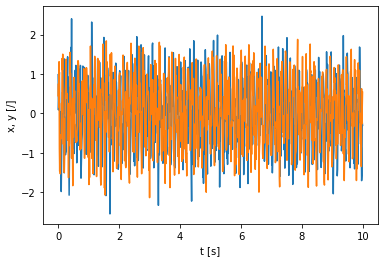

In [13]:
plt.figure()
plt.plot(t, x, label='x(t)')
plt.plot(t, y, label='y(t)')
plt.xlabel('t [s]')
plt.ylabel('x, y [/]');

In [14]:
freq, S_xy = csd(x, y, fs, window='hamming', nperseg=2*fs)
df = freq[1] - freq[0]
df

0.5

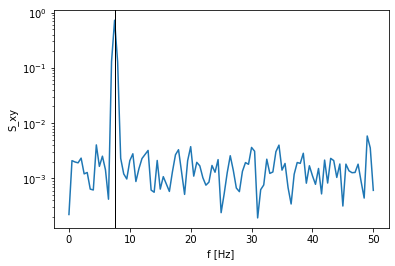

In [17]:
plt.semilogy(freq, np.abs(S_xy))
plt.axvline(x=f, c='k', lw=1)
plt.xlabel('f [Hz]')
plt.ylabel('S_xy');

## Domača naloga

:::{admonition} Domača naloga
:class: warning

V okolju Jupyter Notebook pripravite kratko poročilo *(od 3 do 10 celic s kodo)* z rezultati in kratkim komentarjem meritev, ki ste jih izvedli na vaji, v katerem naj bodo razvidni podatki naloge. Poročilo naj vsebuje tudi:

* prikaz časovne vrste ter amplitudnega spektra vaše meritve (pri vzbujanju v točki, podani v podatkih naloge),
* prikaz frekvenčne prenosne funkcije v vaši izmerjeni točki ($i$), ki jo ocenite z $\alpha_i(\omega) = X_i(\omega) / F_i(\omega)$.
* prikaz frekvenčne prenosne funkcije v vaši izmerjeni točki ($i$), izračunane s cenilko $H_1(\omega)$. Pri tem povprečite spektre izmerjenih signalov, razdeljenih na segmente dolžine 2 s.


**Dodatek**: 
* Izračunajte in prikažite obe cenilki frekvenčne prenosne funkcije ($H_1$, $H_2$). 
    * Križne- in avtospektre signalov pri tem izračunajte s povprečenjem z metodo Welch ([`scipy.signal.csd`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.csd.html)),
    * posamezni segment Welch izračuna PSD in CSD naj bo $1 s$ zajetega signala, s 50% prekrivanjem segmentov,
    * na posameznem segmentu naj se, za zagotavljanje predpostavke periodičnosti, uporabi [`Hamming`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.hamming.html#scipy.signal.windows.hamming) okno.
* Na kratko prikažite in komentirajte vpliv *dolžine segmenta* Welch metode ter *obliko uporabljenega okna*.
* Izračunajte in prikažite tudi koherenco meritve FRF $\gamma^2_{fx}(\omega)$.

Poročilo oddajte tudi v `.pdf` obliki (glejte [navodila za oddajo domačih nalog](intro-domace-naloge)).

:::